# 02 Optimising Serial Code




## Mental model of a memory

### high level view
CPU → L1 cache 
L1 filled from L2, L2 filled from L3, L3 filled from main memory
so in a closer cache = faster
cache miss = pulling from main memory!

### Cache lines and row/column-major
goal = minimise cache misses
cahce line = next chunck in array

In [118]:
using Pkg
Pkg.activate("../") #activate the packes in the .toml files!

  Activating project at `c:\Users\olivi\Documents\SciMLBook`


Julia = a column major languag! statck column after column!

In [119]:
using BenchmarkTools
A = rand(100,100)
B = rand(100,100)
C = rand(100,100)
function inner_rows(C,A,B)
    for i in 1:100, j in 1:100
        C[i,j] = A[i,j] + B[i,j]
    end
end
@btime inner_rows(C,A,B)

  8.233 μs (0 allocations: 0 bytes)


So in this code, you go 1 row at a time (so i = 1, j = 1 -> 100, then i = 2...). So this is slower in Julia as it is column major!

In [120]:
function inner_rows(C,A,B)
    for j in 1:100, i in 1:100
        C[i,j] = A[i,j] + B[i,j]
    end
end
@btime inner_rows(C,A,B)

  4.357 μs (0 allocations: 0 bytes)


So faster, as you go 1 column at a time now!

### Lower level view: stack and heap
stack: static allocation, size of varaiblaes known at compile time! To Heap if not
### Heap allocations and spped
heap allocations = coslty!

In [122]:
function inner_alloc!(C,A,B)
    for j in 1:100, i in 1:100
      val = [A[i,j] + B[i,j]] #heap allocation
      C[i,j] = val[1]
    end
  end
  @btime inner_alloc!(C,A,B)

  175.700 μs (10000 allocations: 625.00 KiB)


In [123]:
function inner_noalloc!(C,A,B)
    for j in 1:100, i in 1:100
      val = A[i,j] + B[i,j] #static -> stack allocation!
      C[i,j] = val[1]
    end
  end
  @btime inner_noalloc!(C,A,B)

  4.114 μs (0 allocations: 0 bytes)


Float64 is allocated to stack and not heap as the size is known!

StaticArrays.jl for statically-sized arrays!!

In [124]:
using StaticArrays
function static_inner_alloc!(C,A,B)
  for j in 1:100, i in 1:100
    val = @SVector [A[i,j] + B[i,j]]
    C[i,j] = val[1]
  end
end
@btime static_inner_alloc!(C,A,B)

  4.500 μs (0 allocations: 0 bytes)


### Mutation to avoid heap allocations

Preallocation of the array (cf. Wetenschappelijk programmeren!)

In [125]:
function inner_noalloc!(C,A,B)
    for j in 1:100, i in 1:100
      val = A[i,j] + B[i,j]
      C[i,j] = val[1]
    end
  end
  @btime inner_noalloc!(C,A,B)

  4.343 μs (0 allocations: 0 bytes)


In [126]:
function inner_alloc(A,B)
    C = similar(A)
    for j in 1:100, i in 1:100
      val = A[i,j] + B[i,j]
      C[i,j] = val[1]
    end
  end
  @btime inner_alloc(A,B)

  8.400 μs (2 allocations: 78.17 KiB)


### Julia's broadcasting mechanism

Array vectorisation = key!  Use `.` on an operator!

In [127]:
A .+ B .+ C

100×100 Matrix{Float64}:
 1.95759   1.24287   1.85569  1.57616   …  2.96207   1.67526   2.31989
 2.10597   1.94274   2.98321  3.59025      0.868032  2.3984    2.94639
 1.40384   0.907911  2.00789  1.57005      2.15884   1.72721   0.292394
 3.07759   2.14276   1.6457   2.29803      2.54037   0.699596  3.30135
 1.3382    0.879605  3.44189  3.08378      1.69884   1.92612   1.66114
 2.02232   1.63395   1.15896  2.87765   …  0.949089  1.83023   1.28534
 3.59892   2.0366    2.53804  0.926695     2.39815   2.19877   0.719024
 1.41869   2.41391   3.04103  1.69399      2.41403   2.1561    2.05501
 2.66341   3.21247   3.10735  0.535433     2.75337   2.04125   2.16414
 2.38798   1.02763   1.37605  2.36593      1.18685   0.518268  3.04939
 ⋮                                      ⋱                      
 1.26755   0.693324  1.20631  2.36529      1.06393   2.11021   1.74911
 2.34553   3.08031   1.40403  1.31149      1.46323   3.88854   1.76508
 2.42129   1.75169   3.77359  2.17406      1.08048   1.69

In [128]:
map((a,b,c)->a+b+c,A,B,C)

100×100 Matrix{Float64}:
 1.95759   1.24287   1.85569  1.57616   …  2.96207   1.67526   2.31989
 2.10597   1.94274   2.98321  3.59025      0.868032  2.3984    2.94639
 1.40384   0.907911  2.00789  1.57005      2.15884   1.72721   0.292394
 3.07759   2.14276   1.6457   2.29803      2.54037   0.699596  3.30135
 1.3382    0.879605  3.44189  3.08378      1.69884   1.92612   1.66114
 2.02232   1.63395   1.15896  2.87765   …  0.949089  1.83023   1.28534
 3.59892   2.0366    2.53804  0.926695     2.39815   2.19877   0.719024
 1.41869   2.41391   3.04103  1.69399      2.41403   2.1561    2.05501
 2.66341   3.21247   3.10735  0.535433     2.75337   2.04125   2.16414
 2.38798   1.02763   1.37605  2.36593      1.18685   0.518268  3.04939
 ⋮                                      ⋱                      
 1.26755   0.693324  1.20631  2.36529      1.06393   2.11021   1.74911
 2.34553   3.08031   1.40403  1.31149      1.46323   3.88854   1.76508
 2.42129   1.75169   3.77359  2.17406      1.08048   1.69

Fusing the operation = faster

In [129]:
function unfused(A,B,C)
    tmp = A .+ B
    tmp .+ C
  end
  @btime unfused(A,B,C);

  12.500 μs (4 allocations: 156.34 KiB)


In [130]:
fused(A,B,C) = A .+ B .+ C
@btime fused(A,B,C);

  7.525 μs (2 allocations: 78.17 KiB)


`.=` is also a vectorised allocation

In [131]:
D = similar(A)
fused!(D,A,B,C) = (D .= A .+ B .+ C)
@btime fused!(D,A,B,C);

  2.489 μs (0 allocations: 0 bytes)


In [132]:
D = similar(A)
non_fused!(D,A,B,C) = (D = A .+ B .+ C)
@btime non_fused!(D,A,B,C);

  6.700 μs (2 allocations: 78.17 KiB)


### note on vectorization and speed

In MATLAB/Python/R, there is a large overhead per operation. This is avoided by vectorising your code as this calls a single C function instead!
In Julia however, looping is NOT slow!! See above: generally the same speed as vectorisation!

### heap allocations from slicing

slice in Julia prodcues a COPY (so a new entity) instead of a view (which is in a way an access to the original object)

In [133]:
A[50,50]

0.30376035319482597

In [134]:
@show A[1]
E = @view A[1:5,1:5] #view instead of default copy!
E[1] = 2.0
@show A[1] #so the value has changed now as E is not a copy of A!

A[1] = 0.6875288658578751
A[1] = 2.0


2.0

### asymptotic cost of heap allocations
O(n) for arrays BUT with large constant factor

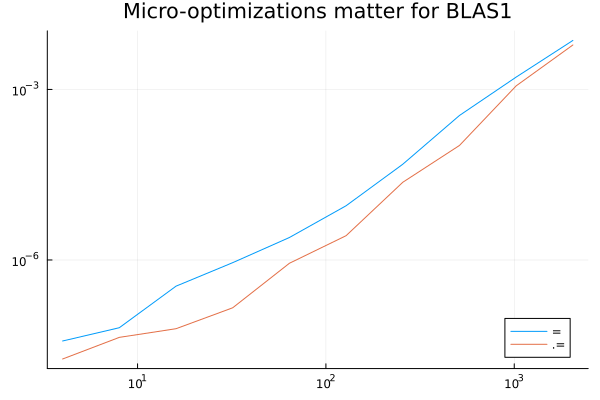

In [135]:
using LinearAlgebra, BenchmarkTools
function alloc_timer(n)
    A = rand(n,n)
    B = rand(n,n)
    C = rand(n,n)
    t1 = @belapsed $A .* $B
    t2 = @belapsed ($C .= $A .* $B) #does have heap allocation I think
    t1,t2
end
ns = 2 .^ (2:11)
res = [alloc_timer(n) for n in ns]
alloc   = [x[1] for x in res]
noalloc = [x[2] for x in res]

using Plots
plot(ns,alloc,label="=",xscale=:log10,yscale=:log10,legend=:bottomright,
     title="Micro-optimizations matter for BLAS1")
plot!(ns,noalloc,label=".=")

### summmary
copy-paste
- Avoid cache misses by reusing values
- Iterate along columns
- Avoid heap allocations in inner loops
- Heap allocations occur when the size of things is not proven at compile-time
- Use fused broadcasts (with mutated outputs) to avoid heap allocations
- Array vectorization confers no special benefit in Julia because Julia loops are as fast as C or Fortran
- Use views instead of slices when applicable
- Avoiding heap allocations is most necessary for O(n) algorithms or algorithms with small arrays
- Use StaticArrays.jl to avoid heap allocations of small arrays in inner loops

## Julia's type inference and the compiler
Julia = JIT compiled. Wiki on jit compilation: *In computing, just-in-time (JIT) compilation (also dynamic translation or run-time compilations)[1] is compilation (of computer code) during execution of a program (at run time) rather than before execution*

2 reasons Julia is fast (covered below)

### 1: Type inference
At the core, everything has a type! 
- C: programmer has to declare the type
- Python: check the type at runtime -> overhead! variables are NOT stack-allocated, as there is no guarantee on the size!
- Julia: check the types BEFORE runtime! 

LLVM = Julia compiler https://en.wikipedia.org/wiki/LLVM

### 2: Type specializations in functions
no types provided -> generic function! but this is NOT a single function, as the function depends on the type!

In [136]:
f(x,y) = x + y

f (generic function with 2 methods)

In [137]:
using InteractiveUtils
@code_llvm f(2,5)

;  @ c:\Users\olivi\Documents\SciMLBook\own_notebooks\02_optimising_serial_code.ipynb:1 within `f`
; Function Attrs: uwtable
define i64 @julia_f_7431(i64 signext %0, i64 signext %1) #0 {
top:
; ┌ @ int.jl:87 within `+`
   %2 = add i64 %1, %0
; └
  ret i64 %2
}


So here ints are used!

In [138]:
@code_llvm f(2.0,5.0)

;  @ c:\Users\olivi\Documents\SciMLBook\own_notebooks\02_optimising_serial_code.ipynb:1 within `f`
; Function Attrs: uwtable
define double @julia_f_7433(double %0, double %1) #0 {
top:
; ┌ @ float.jl:383 within `+`
   %2 = fadd double %0, %1
; └
  ret double %2
}


While here doubles are used! This is possible because many methods are defined for the plus operator (404 as of now)

In [139]:
mehtods_list = methods(+)
print(length(mehtods_list))


404

In [140]:
@code_warntype f(2,5)

MethodInstance for f(::Int64, ::Int64)
  from f(x, y) in Main at c:\Users\olivi\Documents\SciMLBook\own_notebooks\02_optimising_serial_code.ipynb:1
Arguments
  #self#::Core.Const(f)
  x::Int64
  y::Int64
Body::Int64
1 ─ %1 = (x + y)::Int64
└──      return %1



In [141]:
@code_warntype f(2.0,5)

MethodInstance for f(::Float64, ::Int64)
  from f(x, y) in Main at c:\Users\olivi\Documents\SciMLBook\own_notebooks\02_optimising_serial_code.ipynb:1
Arguments
  #self#::Core.Const(f)
  x::Float64
  y::Int64
Body::Float64
1 ─ %1 = (x + y)::Float64
└──      return %1



Now int is promoted to float64!

### type stability
Respected in above cases. It means that the outcome is known at compile time! so int + float -> ALWAYS float!

In [142]:
function h(x,y)
    out = x + y
    rand() < 0.5 ? out : Float64(out)
  end

h (generic function with 1 method)

NOT type stable, as the output depends on this random value!

In [143]:
@code_warntype h(2,5)

MethodInstance for h(::Int64, ::Int64)
  from h(x, y) in Main at c:\Users\olivi\Documents\SciMLBook\own_notebooks\02_optimising_serial_code.ipynb:1
Arguments
  #self#::Core.Const(h)
  x::Int64
  y::Int64
Locals
  out::Int64
Body::Union{Float64, Int64}
1 ─      (out = x + y)
│   %2 = Main.rand()::Float64
│   %3 = (%2 < 0.5)::Bool
└──      goto #3 if not %3
2 ─      return out
3 ─ %6 = Main.Float64(out)::Float64
└──      return %6



### multiple dispatch
you can tell a function how to act differently DEPENDING on the input type :)

In [144]:
ff(x::Int,y::Int) = 2x + y
ff(x::Float64,y::Float64) = x/y
@show ff(2,5)
@show ff(2.0,5.0)

ff(2, 5) = 9
ff(2.0, 5.0) = 0.4


0.4

In [145]:
methods(ff)

# 2 methods for generic function "ff":
[1] ff(x::Int64, y::Int64) in Main at c:\Users\olivi\Documents\SciMLBook\own_notebooks\02_optimising_serial_code.ipynb:1
[2] ff(x::Float64, y::Float64) in Main at c:\Users\olivi\Documents\SciMLBook\own_notebooks\02_optimising_serial_code.ipynb:2

Abstract types in julia:

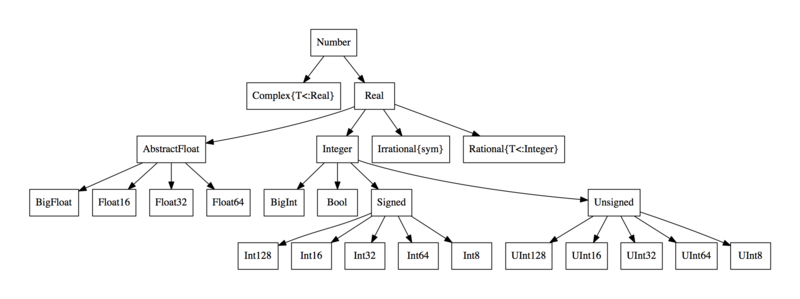

If no method exists for your input types -> MethodError!.

KEY: if types are known, the code is optimised!

### any fallabcks
Any = the maximal supertype! it falls back to all possible input values!

### ambiguities

avoid this! means that multiple methods are 'most strict' for your inputs

### untyped containers

type inference is RUINED with untyped containers

In [146]:
a = [1.0, 2.0,3.0]

3-element Vector{Float64}:
 1.0
 2.0
 3.0

this is a typed container!

In [147]:
b = ["1.0",2,2.0]

3-element Vector{Any}:
  "1.0"
 2
 2.0

ANy type :( )

In [148]:
function bad_container(a)
    a[2]
  end
@code_warntype bad_container(b)

MethodInstance for bad_container(::Vector{Any})
  from bad_container(a) in Main at c:\Users\olivi\Documents\SciMLBook\own_notebooks\02_optimising_serial_code.ipynb:1
Arguments
  #self#::Core.Const(bad_container)
  a::Vector{Any}
Body::Any
1 ─ %1 = Base.getindex(a, 2)::Any
└──      return %1



So clear that the type inference is broken know, no idea on output of the type...
### Type definitions
#### Value types and isbits

if types can be fully inferred = value type! check with `isbits`

In [149]:
isbits(1.0)

true

In [150]:
isbits(1)

true

In [151]:
struct MyComplex
    real::Float64
    imag::Float64
  end
  isbits(MyComplex(1.0,1.0))

true

In [152]:
struct MyParameterizedComplex{T}
    real::T
    imag::T
end
isbits(MyParameterizedComplex(1.0,1.0))

true

In the way above, you don't have to specify the type!

In [153]:
typeof(1.0f0)

Float32

In [154]:
struct MySlowComplex
    real
    imag
end
isbits(MySlowComplex(1.0,1.0))

false

In [155]:
struct MySlowComplex2
    real::AbstractFloat
    imag::AbstractFloat
end
isbits(MySlowComplex2(1.0,1.0))

false

Note: the number types, even ones such as Int, Float64, and Complex, are all themselves implemented in pure Julia!
Note2: isbits compiles down to bit operations from pure Julia, which means that these types can directly compile to GPU kernels through CUDAnative without modification.

### Function barriers


In [156]:
x = Number[1.0,3] #slow container type!
function r(x)
    a = 4
    b = 2
    for i in 1:100
      c = f(x[1],a)
      d = f(b,c)
      a = f(d,x[2])
    end
    a
  end
  @btime r(x)

  4.400 μs (300 allocations: 4.69 KiB)


604.0

In [157]:
x_fast = [1.0,3.0]
@btime r(x_fast)

  477.041 ns (1 allocation: 16 bytes)


604.0

Splitting up the bad container will be faster!

In [158]:
function _s(x1,x2)
    a = 4
    b = 2
    for i in 1:100
      c = f(x1,a)
      d = f(b,c)
      a = f(d,x2)
    end
    a
end
s(x) = _s(x[1],x[2])
@btime s(x)

  279.530 ns (1 allocation: 16 bytes)


604.0

In [159]:
isbits(x)#!! 

false

In [160]:
@code_warntype r(x)

MethodInstance for r(::Vector{Number})
  from r(x) in Main at c:\Users\olivi\Documents\SciMLBook\own_notebooks\02_optimising_serial_code.ipynb:2
Arguments
  #self#::Core.Const(r)
  x::Vector{Number}
Locals
  @_3::Union{Nothing, Tuple{Int64, Int64}}
  b::Int64
  a::Any
  i::Int64
  d::Any
  c::Any
Body::Any
1 ─       (a = 4)
│         (b = 2)
│   %3  = (1:100)::Core.Const(1:100)
│         (@_3 = Base.iterate(%3))
│   %5  = (@_3::Core.Const((1, 1)) === nothing)::Core.Const(false)
│   %6  = Base.not_int(%5)::Core.Const(true)
└──       goto #4 if not %6
2 ┄ %8  = @_3::Tuple{Int64, Int64}
│         (i = Core.getfield(%8, 1))
│   %10 = Core.getfield(%8, 2)::Int64
│   %11 = Base.getindex(x, 1)::Number
│         (c = Main.f(%11, a))
│         (d = Main.f(b::Core.Const(2), c))
│   %14 = d::Any
│   %15 = Base.getindex(x, 2)::Number
│         (a = Main.f(%14, %15))
│         (@_3 = Base.iterate(%3, %10))
│   %18 = (@_3 === nothing)::Bool
│   %19 = Base.not_int(%18)::Bool
└──       goto #4 if not 

### specialisation at compile time

In [161]:
function fff(x)
    if x isa Int
      y = 2
    else
      y = 4.0
    end
    x + y
  end

fff (generic function with 1 method)

In [162]:
@code_llvm fff(1)

;  @ c:\Users\olivi\Documents\SciMLBook\own_notebooks\02_optimising_serial_code.ipynb:1 within `fff`
; Function Attrs: uwtable
define i64 @julia_fff_7479(i64 signext %0) #0 {
top:
;  @ c:\Users\olivi\Documents\SciMLBook\own_notebooks\02_optimising_serial_code.ipynb:7 within `fff`
; ┌ @ int.jl:87 within `+`
   %1 = add i64 %0, 2
; └
  ret i64 %1
}


So optimised at compile time as it KNOWS the input is an INT!

### Global scope and optimisations

so e.g. directly in REPL. Here, types cannot be inferred, as you can change the type at any time (by typing a new command)

## Overheads of individual operators

Each operation has a cost!

### Bounds checking
= what gives error if you're out of bounds! Removing this maks code faster

### SIMD
single input multiple data. E.g. adding 4 floats in 1 clock cycle!

### FMA
fused multiply-add so .e.g x*y+z is fused

### Inlining
if function call is deemed cheap enough, than combined into single call!